In [134]:
# 1. Setup y carga librerías
import os, pandas as pd, geopandas as gpd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from sqlalchemy import create_engine
from dotenv import load_dotenv
load_dotenv()
sns.set_palette('viridis')
POSTGRES_USER=os.getenv('POSTGRES_USER'); POSTGRES_PASSWORD=os.getenv('POSTGRES_PASSWORD')
POSTGRES_HOST=os.getenv('POSTGRES_HOST','localhost'); POSTGRES_PORT=os.getenv('POSTGRES_PORT','5432'); POSTGRES_DB=os.getenv('POSTGRES_DB')
engine = create_engine(f'postgresql://{POSTGRES_USER}:{POSTGRES_PASSWORD}@{POSTGRES_HOST}:{POSTGRES_PORT}/{POSTGRES_DB}')
print('Conexión lista')

Conexión lista


In [135]:
# 2. Carga de datasets clave
from pathlib import Path
processed_dir = Path('../data/processed')

def load_gdf(schema, table):
    try:
        return gpd.read_postgis(f'SELECT * FROM {schema}.{table}', engine, geom_col='geometry')
    except Exception as e:
        print(f'Error cargando {schema}.{table}:', e)
        return None
manz_attr = load_gdf('processed_data','manzanas_atributos')
uso = load_gdf('processed_data','manzanas_uso_suelo')
net_nodes = load_gdf('processed_data','network_nodes_metrics')
metrics = pd.read_sql('SELECT * FROM processed_data.metrics_manzanas', engine)
print('Shapes:', len(manz_attr) if manz_attr is not None else None, len(metrics))
required_files = ['sentinel2_ndvi.tif','sentinel2_ndvi_32719.tif','metrics_manzanas.csv']
for f in required_files:
    exists = (processed_dir / f).exists()
    print(f'Check {f}:', 'OK' if exists else 'FALTA')
# Se validará lisa_clusters.geojson tras su export en celda 8D

Shapes: 792 792
Check sentinel2_ndvi.tif: OK
Check sentinel2_ndvi_32719.tif: OK
Check metrics_manzanas.csv: OK


In [136]:
# 3. Unificación de atributos clave por manzana (+ densidad vial derivada)
# Selección mínima de columnas relevantes para exploración
merged = metrics.copy()
# Asegurar alias clave
key = 'manzent' if 'manzent' in merged.columns else ('MANZENT' if 'MANZENT' in merged.columns else merged.columns[0])
if manz_attr is not None:
    geo_subset = manz_attr[[key, 'geometry']].copy()
    geo_subset.loc[:, key] = geo_subset[key].astype(str)
    merged.loc[:, key] = merged[key].astype(str)
    merged_geo = geo_subset.merge(merged, on=key, how='left')
else:
    merged_geo = None
# Densidad vial derivada si faltante
if merged_geo is not None:
    if 'road_density_m_per_km2' not in merged_geo.columns and 'road_length_m' in merged_geo.columns:
        # Buscar área en metros cuadrados
        area_col = None
        for cand in ['area_m2','Shape__Area','shape_area','AREA']:
            if cand in merged_geo.columns:
                area_col = cand
                break
        if area_col is not None:
            merged_geo['road_density_m_per_km2'] = merged_geo.apply(lambda r: r['road_length_m'] / (r[area_col]/1e6) if r[area_col] and r[area_col] > 0 else np.nan, axis=1)
            print('Creada road_density_m_per_km2 a partir de road_length_m y', area_col)
        else:
            print('No se encontró columna de área para derivar densidad vial.')
numeric_cols = [c for c in merged.columns if merged[c].dtype != 'object' and c not in ['geometry']]
print('Columnas merged:', merged.columns.tolist()[:15])

Columnas merged: ['MANZENT', 'area_m2', 'edificios_count', 'amenidades_count', 'ndvi_mean', 'FID', 'CUT', 'REGION_x', 'PROVINCIA_x', 'COMUNA_x', 'Shape__Area', 'Shape__Length', 'NOMBRE_DISTRITO', 'CODIGO_DISTRITO', 'ZONA_CENSAL']


In [137]:
# 4. Estadísticas descriptivas
desc_cols = [c for c in merged.columns if merged[c].dtype!='object' and c not in ['geometry']]
stats = merged[desc_cols].describe().T
stats[['mean','std','min','max']].head(10)

,mean,std,min,max
MANZENT,1.312904e+13,1.984625e+07,1.312901e+13,1.312907e+13
area_m2,1.015101e+04,1.862798e+04,3.987385e+02,2.286961e+05
edificios_count,2.882576e+00,7.183532e+00,0.000000e+00,4.700000e+01
amenidades_count,3.308081e-01,9.771914e-01,0.000000e+00,1.400000e+01
ndvi_mean,9.971780e-02,3.805254e-02,2.332881e-02,2.873537e-01
FID,3.271956e+04,9.852158e+02,3.151400e+04,3.388300e+04
CUT,1.312900e+04,0.000000e+00,1.312900e+04,1.312900e+04
Shape__Area,1.463870e+04,2.685940e+04,5.750156e+02,3.297089e+05
Shape__Length,5.192735e+02,4.957303e+02,1.308755e+02,7.017620e+03
CODIGO_DISTRITO,3.869949e+00,1.984645e+00,1.000000e+00,7.000000e+00


In [138]:
# 4A. Transformaciones log para variables sesgadas y resumen de skew
skew_candidates = ['edificios_count','amenidades_count','TOTAL_PERSONAS','TOTAL_VIV_PARTICULARES','area_m2']
for col in skew_candidates:
    if col in merged.columns:
        merged[f'log1p_{col}'] = np.log1p(merged[col])
        if merged_geo is not None and col in merged_geo.columns:
            merged_geo[f'log1p_{col}'] = np.log1p(merged_geo[col])
skew_report = {}
for col in skew_candidates:
    if col in merged.columns:
        skew_report[col] = merged[col].skew()
        skew_report[f'log1p_{col}'] = merged[f'log1p_{col}'].skew()
print('Skew original vs log1p:', skew_report)

Skew original vs log1p: {'edificios_count': 3.394419217919976, 'log1p_edificios_count': 1.6191271610653897, 'amenidades_count': 6.445921670449882, 'log1p_amenidades_count': 2.4698557952782045, 'TOTAL_PERSONAS': 8.335687440047733, 'log1p_TOTAL_PERSONAS': -0.29701174612973713, 'TOTAL_VIV_PARTICULARES': 7.976229966335047, 'log1p_TOTAL_VIV_PARTICULARES': 0.7397976296412245, 'area_m2': 6.081547522336318, 'log1p_area_m2': 1.0271475176030087}


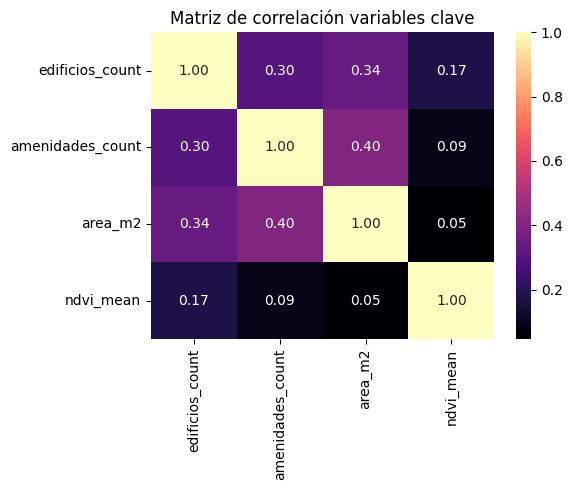

In [139]:
# 5. Correlaciones básicas entre variables numéricas seleccionadas
sel = [col for col in ['edificios_count','amenidades_count','area_m2','ndvi_mean','road_length_m','road_density_m_per_km2'] if col in merged.columns]
corr = merged[sel].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='magma', fmt='.2f')
plt.title('Matriz de correlación variables clave')
plt.tight_layout()
plt.show()

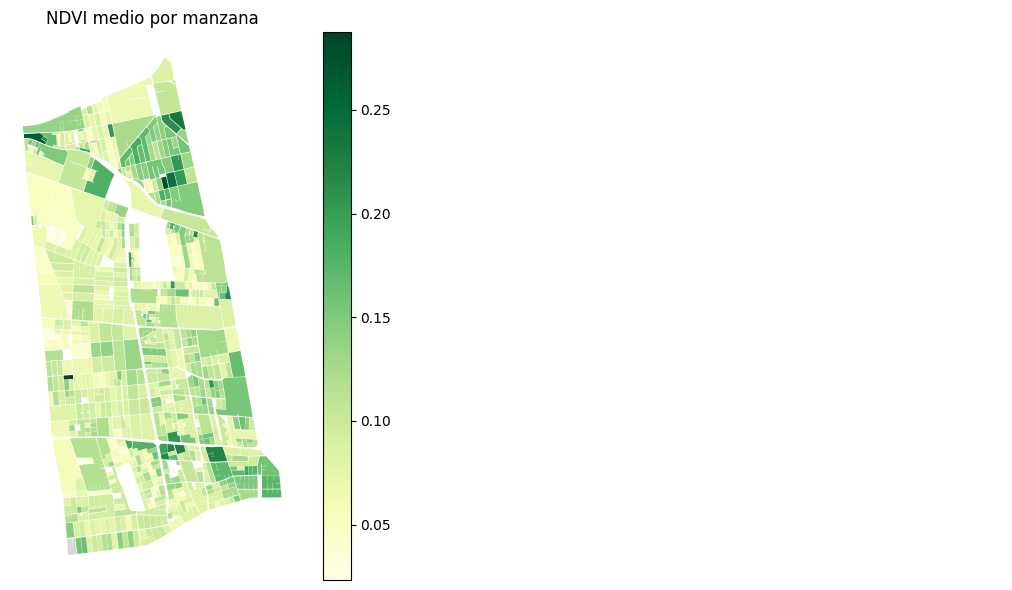

In [140]:
# 6. Mapas temáticos: NDVI y densidad vial
if merged_geo is not None:
    fig, axes = plt.subplots(1,2, figsize=(12,6))
    if 'ndvi_mean' in merged_geo.columns:
        merged_geo.plot(column='ndvi_mean', ax=axes[0], cmap='YlGn', legend=True, missing_kwds={'color':'lightgrey'})
        axes[0].set_title('NDVI medio por manzana')
    if 'road_density_m_per_km2' in merged_geo.columns:
        merged_geo.plot(column='road_density_m_per_km2', ax=axes[1], cmap='OrRd', legend=True, missing_kwds={'color':'lightgrey'})
        axes[1].set_title('Densidad vial (m/km²)')
    for ax in axes: ax.axis('off')
    plt.tight_layout(); plt.show()
else:
    print('No hay geometría de manzanas para mapear.')

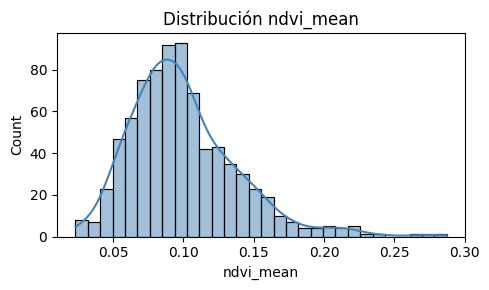

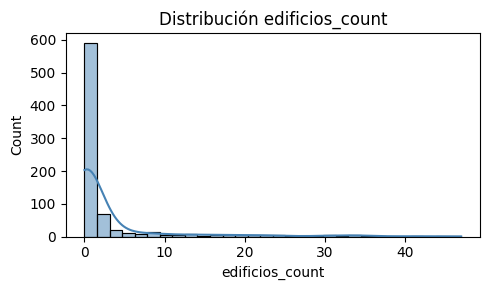

In [141]:
# 7. Distribución de NDVI y edificios (histogramas)
plot_vars = [v for v in ['ndvi_mean','edificios_count'] if v in merged.columns]
for v in plot_vars:
    plt.figure(figsize=(5,3))
    sns.histplot(merged[v], kde=True, bins=30, color='steelblue')
    plt.title(f'Distribución {v}')
    plt.tight_layout()
    plt.show()

/opt/conda/lib/python3.11/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 792 disconnected components.
 There are 792 islands with ids: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

Queen produjo solo islas; usando KNN k=8.
Moran's I (ndvi_mean): 0.3520
P-value (norm): 0.0000 | p_perm=0.0010


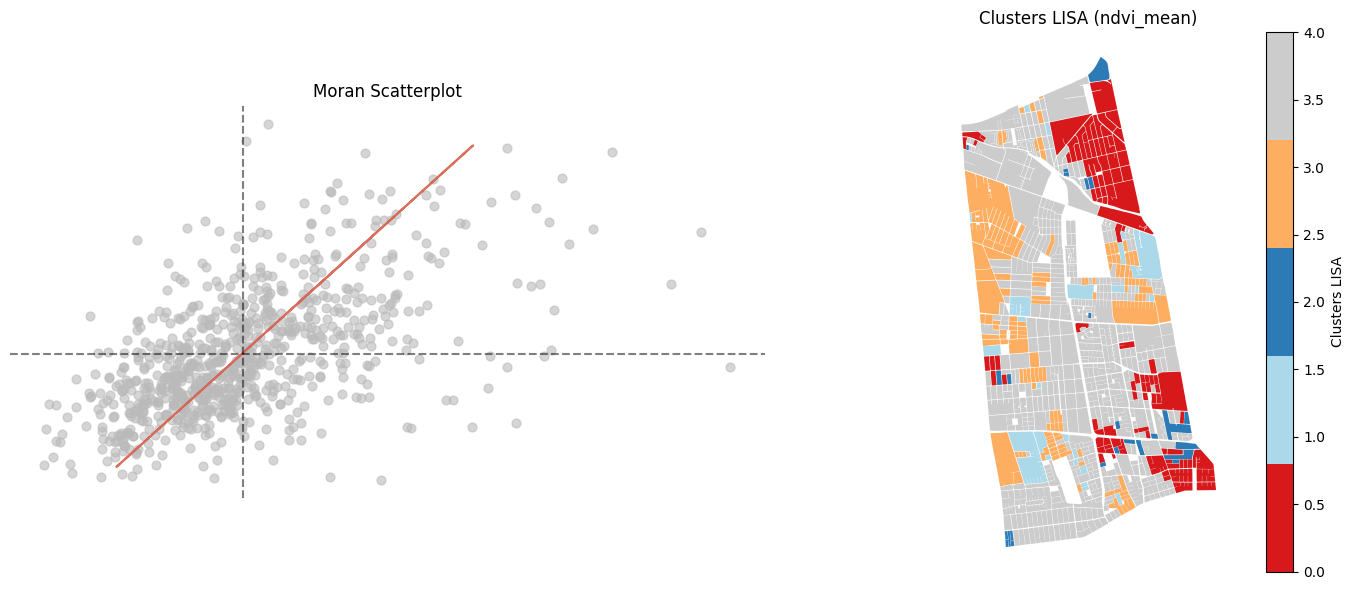

In [142]:
# 8. Autocorrelación espacial (Moran Global / Local) (use_index explicit)
# Excluye la manzana huérfana; fallback a KNN si Queen produce islas
try:
    import pysal
    from pysal.lib import weights
    from pysal.explore import esda
    from libpysal.weights import KNN
    import splot.esda as splot_esda
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    if merged_geo is not None:
        gdf_valid = merged_geo[merged_geo.geometry.notnull()].copy()
        if 'manzent' in gdf_valid.columns:
            gdf_valid = gdf_valid[gdf_valid['manzent'] != '13129991999999']
        gdf_valid = gdf_valid[gdf_valid.geometry.is_valid]
        target_var = 'ndvi_mean' if 'ndvi_mean' in gdf_valid.columns else [c for c in gdf_valid.columns if c not in ['geometry','manzent','MANZENT'] and gdf_valid[c].dtype != 'object'][0]
        w = weights.Queen.from_dataframe(gdf_valid, use_index=False)
        if len(w.islands) == len(gdf_valid):
            coords = np.array([[geom.centroid.x, geom.centroid.y] for geom in gdf_valid.geometry])
            k = min(8, len(coords)-1)
            w = KNN.from_array(coords, k=k)
            print(f"Queen produjo solo islas; usando KNN k={k}.")
        w.transform = 'r'
        y = gdf_valid[target_var].fillna(gdf_valid[target_var].mean())
        mi = esda.Moran(y, w)
        lisa = esda.Moran_Local(y, w)
        print(f"Moran's I ({target_var}): {mi.I:.4f}")
        print(f"P-value (norm): {mi.p_norm:.4f} | p_perm={mi.p_sim:.4f}")
        fig, axes = plt.subplots(1, 2, figsize=(14,6))
        splot_esda.moran_scatterplot(mi, ax=axes[0])
        axes[0].set_title('Moran Scatterplot')
        sig = lisa.p_sim < 0.05
        quad = lisa.q
        cluster_labels = np.where(sig & (quad==1), 'Alto-Alto',
                           np.where(sig & (quad==2), 'Bajo-Alto',
                           np.where(sig & (quad==3), 'Bajo-Bajo',
                           np.where(sig & (quad==4), 'Alto-Bajo','No Sig.'))))
        gdf_valid['lisa_cluster'] = cluster_labels
        merged_geo.loc[gdf_valid.index, 'lisa_cluster'] = gdf_valid['lisa_cluster']
        cat_codes = pd.Categorical(gdf_valid['lisa_cluster'])
        gdf_valid['cluster_code'] = cat_codes.codes
        cmap = ['#d7191c','#abd9e9','#2c7bb6','#fdae61','#cccccc']
        gdf_valid.plot(column='cluster_code', ax=axes[1], cmap=mcolors.ListedColormap(cmap), legend=True,
                       legend_kwds={'label':'Clusters LISA'})
        axes[1].set_title(f'Clusters LISA ({target_var})')
        for ax in axes: ax.axis('off')
        plt.tight_layout(); plt.show()
    else:
        print('Geometría no disponible para análisis espacial.')
except Exception as e:
    print('Error en cálculo Moran/LISA. Verifique dependencias pysal/splot:', e)

In [143]:
# 8G. Moran Bivariado (ndvi_mean vs densidad vial y edificios_count) (use_index explicit)
try:
    from pysal.explore import esda
    from pysal.lib import weights
    from libpysal.weights import KNN
    import numpy as np
    if merged_geo is not None and 'ndvi_mean' in merged_geo.columns:
        gdf_bv = merged_geo[merged_geo.geometry.notnull()].copy()
        gdf_bv = gdf_bv[gdf_bv.geometry.is_valid]
        if 'manzent' in gdf_bv.columns:
            gdf_bv = gdf_bv[gdf_bv['manzent'] != '13129991999999']
        w_bv = weights.Queen.from_dataframe(gdf_bv, use_index=False)
        if len(w_bv.islands) == len(gdf_bv):
            coords = np.array([[geom.centroid.x, geom.centroid.y] for geom in gdf_bv.geometry])
            k = min(8, len(coords)-1)
            w_bv = KNN.from_array(coords, k=k)
            print(f"Queen produjo solo islas en bivariado; usando KNN k={k}.")
        w_bv.transform='r'
        targets = []
        if 'road_density_m_per_km2' in gdf_bv.columns: targets.append('road_density_m_per_km2')
        if 'edificios_count' in gdf_bv.columns: targets.append('edificios_count')
        if not targets:
            print('No hay variables secundarias para Moran Bivariado.')
        else:
            from esda.moran import Moran_BV
            for other in targets:
                y1 = gdf_bv['ndvi_mean'].fillna(gdf_bv['ndvi_mean'].mean())
                y2 = gdf_bv[other].fillna(gdf_bv[other].mean())
                mb = Moran_BV(y1, y2, w_bv)
                print(f'Moran Bivariado NDVI vs {other}: I={mb.I:.4f} p_perm={mb.p_sim:.4f}')
    else:
        print('NDVI no disponible para Moran Bivariado.')
except Exception as e:
    print('Error en Moran Bivariado:', e)

Queen produjo solo islas en bivariado; usando KNN k=8.
Moran Bivariado NDVI vs edificios_count: I=0.1527 p_perm=0.0010


/opt/conda/lib/python3.11/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 792 disconnected components.
 There are 792 islands with ids: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

/opt/conda/lib/python3.11/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 792 disconnected components.
 There are 792 islands with ids: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

Queen produjo solo islas en significancia; usando KNN k=8.


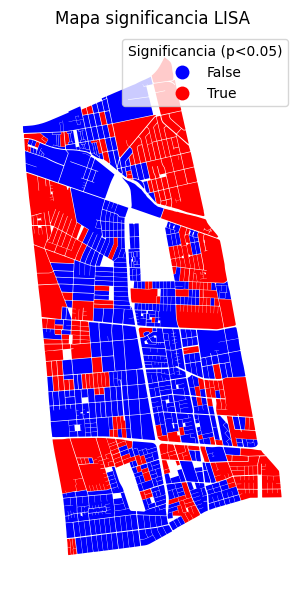

In [144]:
# 8F. Mapa de significancia LISA (p<0.05) (use_index explicit)
if merged_geo is not None and 'lisa_cluster' in merged_geo.columns:
    try:
        from pysal.lib import weights
        from pysal.explore import esda
        from libpysal.weights import KNN
        import numpy as np, matplotlib.pyplot as plt
        gdf_sig = merged_geo[merged_geo.geometry.notnull()].copy()
        gdf_sig = gdf_sig[gdf_sig.geometry.is_valid]
        if 'manzent' in gdf_sig.columns:
            gdf_sig = gdf_sig[gdf_sig['manzent'] != '13129991999999']
        w2 = weights.Queen.from_dataframe(gdf_sig, use_index=False)
        if len(w2.islands) == len(gdf_sig):
            coords = np.array([[geom.centroid.x, geom.centroid.y] for geom in gdf_sig.geometry])
            k = min(8, len(coords)-1)
            w2 = KNN.from_array(coords, k=k)
            print(f"Queen produjo solo islas en significancia; usando KNN k={k}.")
        w2.transform='r'
        target_var = 'ndvi_mean' if 'ndvi_mean' in gdf_sig.columns else [c for c in gdf_sig.columns if c not in ['geometry','manzent','MANZENT'] and gdf_sig[c].dtype != 'object'][0]
        y2 = gdf_sig[target_var].fillna(gdf_sig[target_var].mean())
        lisa2 = esda.Moran_Local(y2, w2)
        gdf_sig['p_value'] = lisa2.p_sim
        gdf_sig['significant'] = gdf_sig['p_value'] < 0.05
        fig, ax = plt.subplots(figsize=(6,6))
        gdf_sig.plot(column='significant', ax=ax, cmap='bwr', legend=True,
                     legend_kwds={'title':'Significancia (p<0.05)'} )
        ax.set_title('Mapa significancia LISA')
        ax.axis('off')
        plt.tight_layout(); plt.show()
    except Exception as e:
        print('Error generando mapa de significancia LISA:', e)
else:
    print('Clusters LISA no disponibles para mapa de significancia.')

Varianza explicada PC1: 0.338
Varianza explicada PC2: 0.108


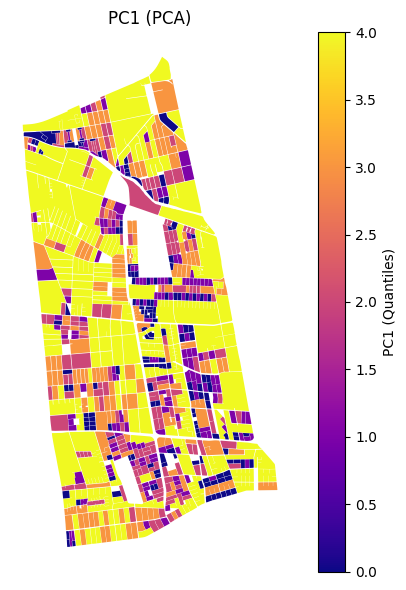

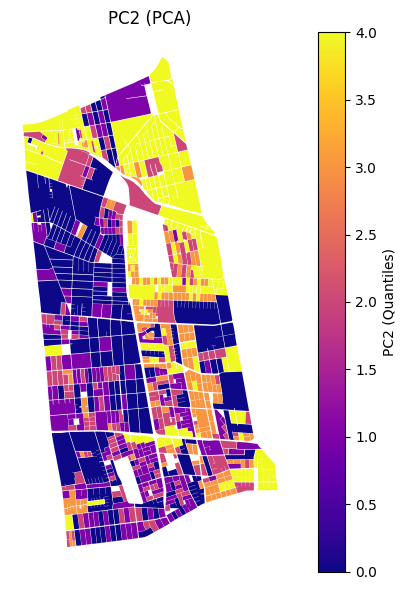

In [145]:
# 8E. PCA espacial multivariado
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
if merged_geo is not None:
    # Selección de variables numéricas para PCA (excluye identificadores y geometry)
    pca_vars = [v for v in numeric_cols if v not in ['manzent','MANZENT'] and merged[v].notnull().sum() > 0]
    df_pca = merged[pca_vars].fillna(merged[pca_vars].median())
    scaler = StandardScaler()
    X = scaler.fit_transform(df_pca)
    pca = PCA(n_components=2)
    comps = pca.fit_transform(X)
    merged_geo['PC1'] = comps[:,0]
    merged_geo['PC2'] = comps[:,1]
    print('Varianza explicada PC1:', round(pca.explained_variance_ratio_[0],3))
    print('Varianza explicada PC2:', round(pca.explained_variance_ratio_[1],3))
    # Mapear PC1 y PC2
    for pc_col in ['PC1','PC2']:
        plot_choropleth(merged_geo, pc_col, scheme='Quantiles', k=5, cmap='plasma', title=f'{pc_col} (PCA)')
else:
    print('No se puede ejecutar PCA: geometría o variables faltantes.')

In [146]:
# 8D. Hotspots & clusters (export resultados)
if merged_geo is not None and 'lisa_cluster' in merged_geo.columns:
    out_clusters = Path('../data/processed/lisa_clusters.geojson')
    try:
        merged_geo.to_file(out_clusters, driver='GeoJSON')
        print('Exportado LISA clusters en', out_clusters)
    except Exception as e:
        print('Error exportando clusters:', e)
else:
    print('No se encontraron resultados LISA para exportar.')

Exportado LISA clusters en ../data/processed/lisa_clusters.geojson


Mapeando variables: ['ndvi_mean', 'edificios_count', 'amenidades_count', 'TOTAL_PERSONAS', 'TOTAL_VIV_PARTICULARES', 'area_m2', 'Shape__Area', 'Shape__Length', 'MANZANA', 'TOTAL_VIV_COLECTIVAS']


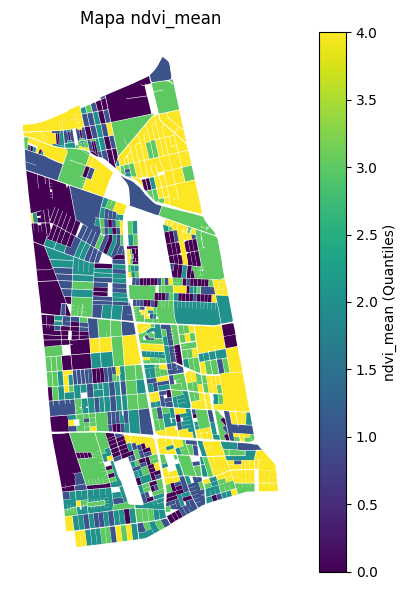

/opt/conda/lib/python3.11/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 3.
  self.bins = quantile(y, k=k)


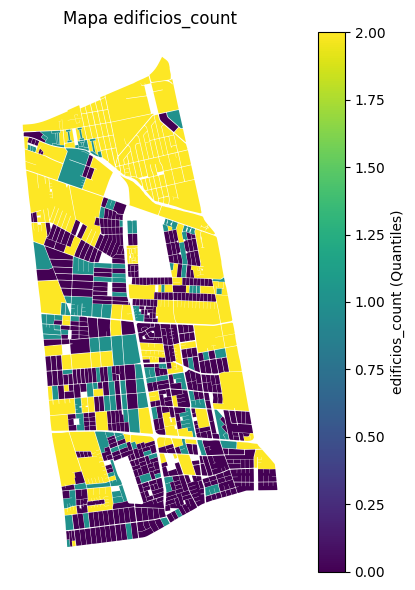

/opt/conda/lib/python3.11/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 2.
  self.bins = quantile(y, k=k)


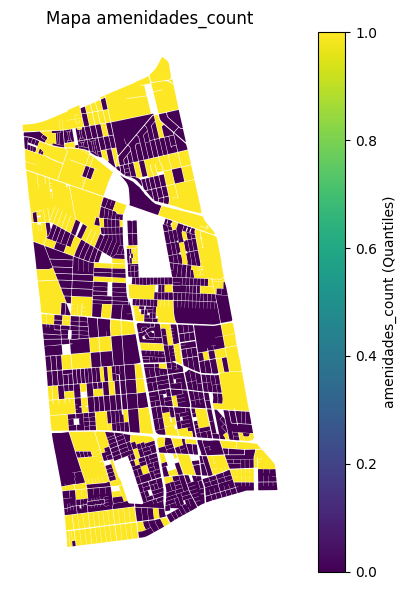

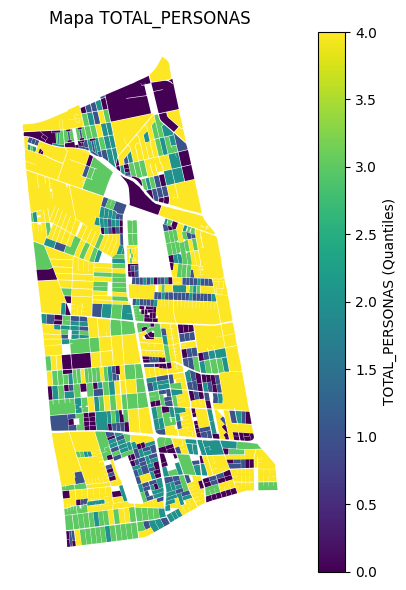

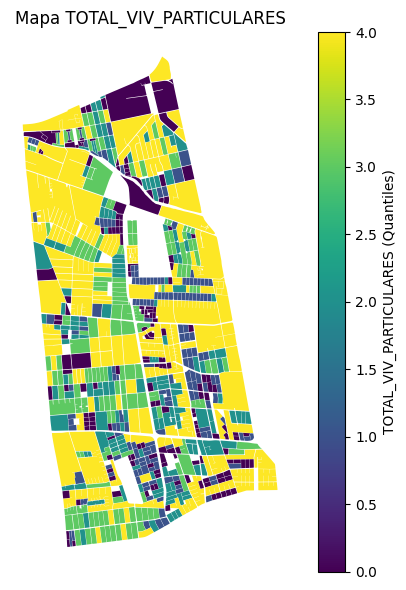

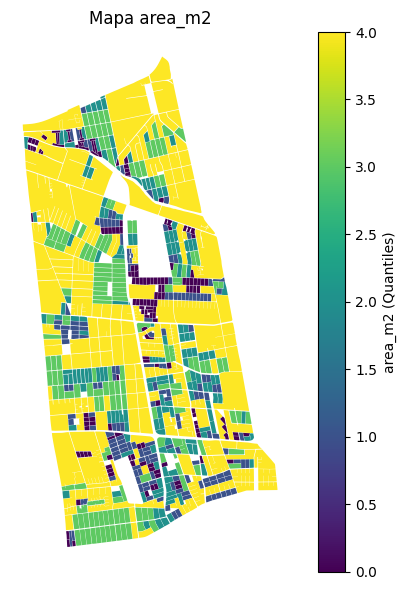

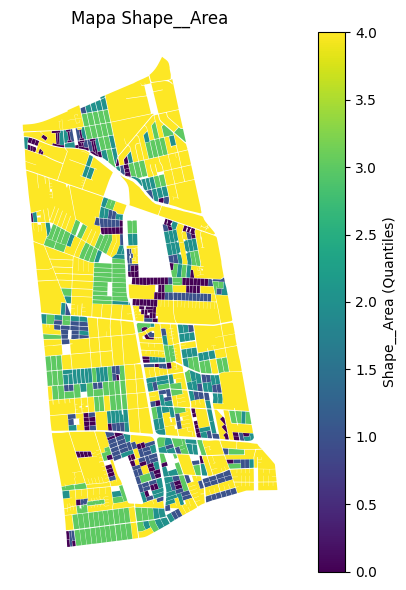

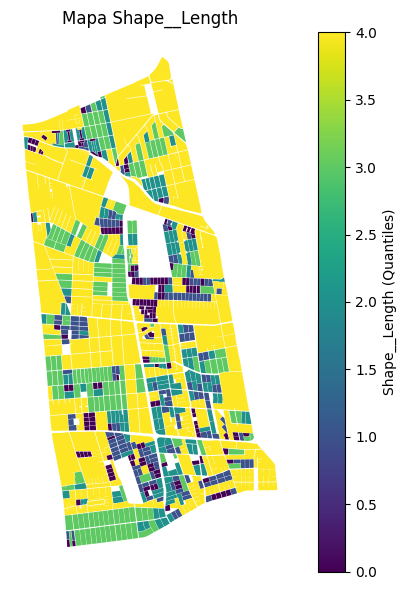

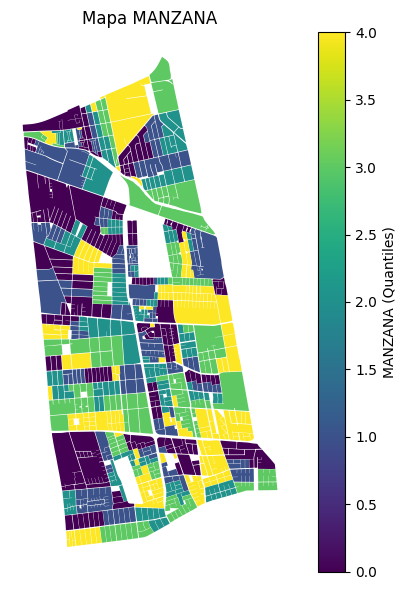

/opt/conda/lib/python3.11/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 2.
  self.bins = quantile(y, k=k)


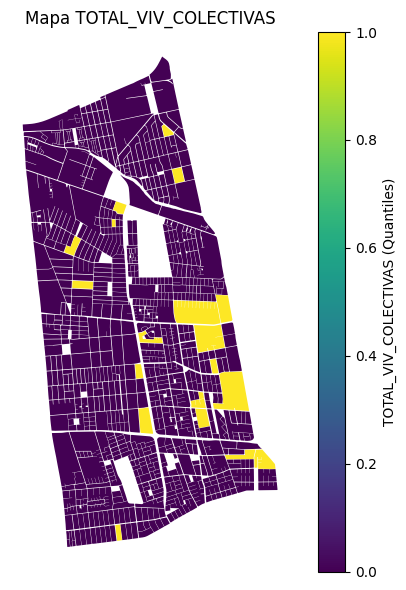

In [147]:
# 8C. Generar al menos 10 mapas temáticos (refinado)
numeric_cols = [c for c in merged.columns if merged[c].dtype != 'object' and c not in ['geometry']]
if merged_geo is not None:
    maps_target = []
    priority_vars = ['ndvi_mean','edificios_count','amenidades_count','TOTAL_PERSONAS','TOTAL_VIV_PARTICULARES','road_density_m_per_km2','road_length_m','area_m2','Shape__Area','Shape__Length']
    for v in priority_vars:
        if v in merged_geo.columns: maps_target.append(v)
    for v in numeric_cols:
        if len(maps_target) >= 10: break
        if v not in maps_target and v in merged_geo.columns and v not in ['geometry','manzent','MANZENT','FID','CUT','CODIGO_DISTRITO','ZONA_CENSAL']:
            maps_target.append(v)
    print('Mapeando variables:', maps_target)
    for v in maps_target:
        plot_choropleth(merged_geo, v, scheme='Quantiles', k=5, cmap='viridis', title=f'Mapa {v}')
else:
    print('No hay geometría para mapas temáticos.')

In [148]:
# 8B. Función para mapas temáticos profesionales
import matplotlib.colors as mcolors
import mapclassify
def plot_choropleth(gdf, column, scheme='Quantiles', k=5, cmap='viridis', title=None):
    try:
        gdf_plot = gdf[gdf[column].notnull()].copy()
        classifier = mapclassify.Quantiles(gdf_plot[column], k=k) if scheme=='Quantiles' else mapclassify.NaturalBreaks(gdf_plot[column], k=k)
        gdf_plot['cls'] = classifier.yb
        fig, ax = plt.subplots(figsize=(6,6))
        gdf_plot.plot(column='cls', ax=ax, cmap=cmap, legend=True,
                      legend_kwds={'label': f'{column} ({scheme})','orientation':'vertical'})
        ax.set_title(title or column)
        ax.axis('off')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f'Error graficando {column}:', e)
available_vars = [v for v in numeric_cols if v not in ['geometry']][:20]
print('Variables disponibles para mapas (primeras 20):', available_vars)

Variables disponibles para mapas (primeras 20): ['MANZENT', 'area_m2', 'edificios_count', 'amenidades_count', 'ndvi_mean', 'FID', 'CUT', 'Shape__Area', 'Shape__Length', 'CODIGO_DISTRITO', 'ZONA_CENSAL', 'MANZANA', 'TOTAL_PERSONAS', 'TOTAL_VIV_PARTICULARES', 'TOTAL_VIV_COLECTIVAS', 'VIV_OCUPA_MORADOR_PRESENTE', 'TOTAL_VIVIENDAS', 'CANTIDAD_HOGARES', 'VIV_TIPO_CASA', 'VIV_TIPO_DEPTO']


In [149]:
# 8A. Estadísticas descriptivas espaciales extendidas
numeric_cols = [c for c in merged.columns if merged[c].dtype != 'object' and c not in ['geometry']]
extended_stats = merged[numeric_cols].describe(percentiles=[0.05,0.25,0.5,0.75,0.95]).T
extended_stats.head(15)

,count,mean,std,min,5%,25%,50%,75%,95%,max
MANZENT,792.0,1.312904e+13,1.984625e+07,1.312901e+13,1.312901e+13,1.312902e+13,1.312904e+13,1.312906e+13,1.312907e+13,1.312907e+13
area_m2,792.0,1.015101e+04,1.862798e+04,3.987385e+02,1.982145e+03,3.314385e+03,5.418676e+03,8.992543e+03,3.268492e+04,2.286961e+05
edificios_count,792.0,2.882576e+00,7.183532e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,1.900000e+01,4.700000e+01
amenidades_count,792.0,3.308081e-01,9.771914e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,1.400000e+01
ndvi_mean,787.0,9.971780e-02,3.805254e-02,2.332881e-02,5.029648e-02,7.439921e-02,9.431699e-02,1.191742e-01,1.676390e-01,2.873537e-01
FID,792.0,3.271956e+04,9.852158e+02,3.151400e+04,3.155355e+04,3.171175e+04,3.309000e+04,3.368525e+04,3.384345e+04,3.388300e+04
CUT,792.0,1.312900e+04,0.000000e+00,1.312900e+04,1.312900e+04,1.312900e+04,1.312900e+04,1.312900e+04,1.312900e+04,1.312900e+04
Shape__Area,792.0,1.463870e+04,2.685940e+04,5.750156e+02,2.857679e+03,4.781513e+03,7.815697e+03,1.297371e+04,4.714528e+04,3.297089e+05
Shape__Length,792.0,5.192735e+02,4.957303e+02,1.308755e+02,2.271907e+02,2.946807e+02,3.949650e+02,5.394575e+02,1.178747e+03,7.017620e+03
CODIGO_DISTRITO,792.0,3.869949e+00,1.984645e+00,1.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,6.000000e+00,7.000000e+00,7.000000e+00


### Nota Moran/LISA
Para análisis completo: separar en celdas dedicadas, crear scatterplot de Moran y mapa LISA (splot). Esto es solo verificación preliminar.

In [150]:
# 9. Guardar subset para futuros análisis
out_path = Path('../data/processed/esda_subset.geojson')
if merged_geo is not None:
    try:
        cols_keep = [c for c in merged_geo.columns if c in ['manzent','ndvi_mean','edificios_count','amenidades_count','road_density_m_per_km2']] + ['geometry']
        subset = merged_geo[cols_keep]
        subset.to_file(out_path, driver='GeoJSON')
        print('Guardado subset ESDA en', out_path)
    except Exception as e:
        print('Error guardando subset ESDA:', e)

Guardado subset ESDA en ../data/processed/esda_subset.geojson


## Checklist Exploratorio (Actualizado)
- [x] Datasets cargados
- [x] Estadísticas descriptivas básicas
- [x] Estadísticas espaciales extendidas (percentiles, variables numéricas)
- [x] Mapas temáticos (>=10 variables)
- [x] Moran Global y Local (LISA) con clusters
- [x] Export clusters LISA
- [x] PCA espacial con primeras dos componentes mapeadas

## Próximos pasos ESDA
1. Añadir análisis bivariado de autocorrelación (Moran Bivariado si aplica).
2. Incluir mapas de significancia LISA separados y boxplots por cluster.
3. Calcular indicadores per cápita (requiere población microdatos agregada).
4. Explorar Geary's C y Getis-Ord G* para hotspots alternativos.
5. Integrar land use proportions si se generan (uso_suelo_unificado).


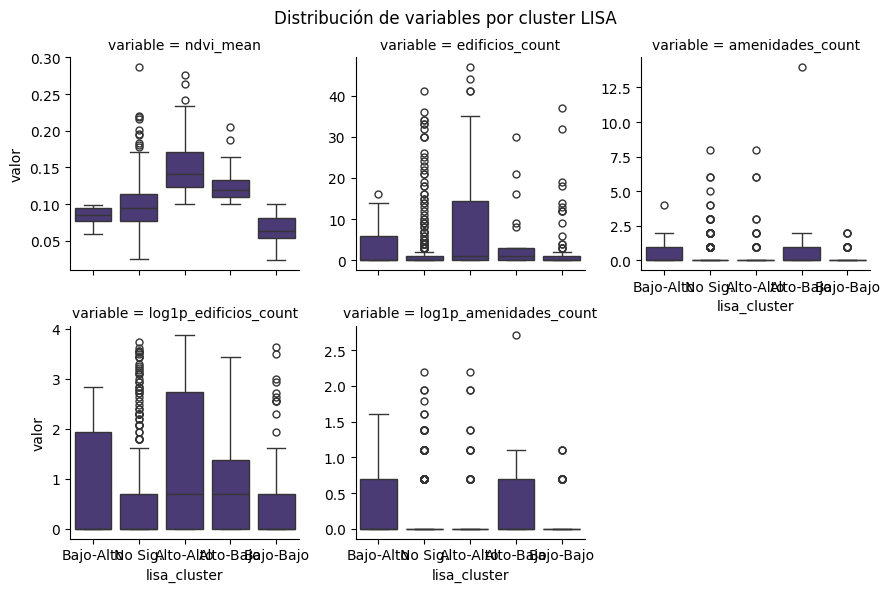

In [151]:
# 10. Boxplots por cluster LISA
if merged_geo is not None and 'lisa_cluster' in merged_geo.columns:
    import seaborn as sns
    import matplotlib.pyplot as plt
    vars_box = [v for v in ['ndvi_mean','edificios_count','amenidades_count','road_density_m_per_km2','log1p_edificios_count','log1p_amenidades_count'] if v in merged_geo.columns]
    df_box = merged_geo[[*vars_box,'lisa_cluster']].dropna(subset=['lisa_cluster']).copy()
    df_long = df_box.melt(id_vars='lisa_cluster', var_name='variable', value_name='valor')
    g = sns.catplot(data=df_long, x='lisa_cluster', y='valor', col='variable', kind='box', col_wrap=3, sharey=False, height=3)
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle('Distribución de variables por cluster LISA')
else:
    print('No hay clusters LISA para boxplots.')

Queen produjo solo islas en Geary/Getis; usando KNN k=8.
Geary's C: 0.6507 p_norm=0.0000


/tmp/ipykernel_48612/2171949799.py:13: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_g = weights.Queen.from_dataframe(gdf_g)
/opt/conda/lib/python3.11/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 792 disconnected components.
 There are 792 islands with ids: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,

Error en Geary/Getis-Ord: Legend.__init__() got an unexpected keyword argument 'label'


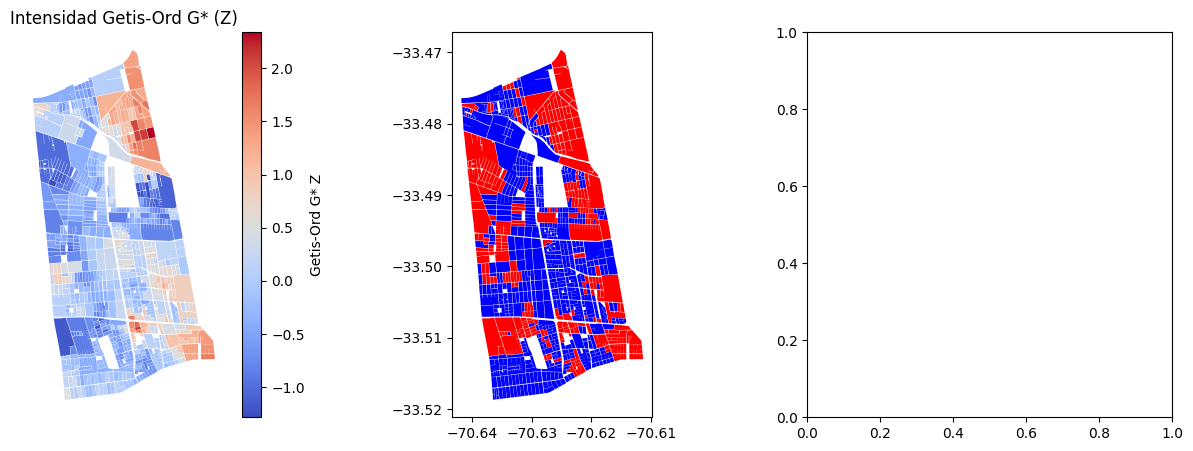

In [152]:
# 11. Geary's C y Getis-Ord G* (Local)
try:
    from pysal.lib import weights
    from libpysal.weights import KNN
    from pysal.explore import esda
    import numpy as np
    import matplotlib.pyplot as plt
    if merged_geo is not None and 'ndvi_mean' in merged_geo.columns:
        gdf_g = merged_geo[merged_geo.geometry.notnull()].copy()
        gdf_g = gdf_g[gdf_g.geometry.is_valid]
        if 'manzent' in gdf_g.columns:
            gdf_g = gdf_g[gdf_g['manzent'] != '13129991999999']
        w_g = weights.Queen.from_dataframe(gdf_g)
        if len(w_g.islands) == len(gdf_g):
            coords = np.array([[geom.centroid.x, geom.centroid.y] for geom in gdf_g.geometry])
            k = min(8, len(coords)-1)
            w_g = KNN.from_array(coords, k=k)
            print(f"Queen produjo solo islas en Geary/Getis; usando KNN k={k}.")
        w_g.transform='r'
        y_geo = gdf_g['ndvi_mean'].fillna(gdf_g['ndvi_mean'].mean())
        # Geary's C
        from esda.geary import Geary
        geary = Geary(y_geo, w_g)
        print(f"Geary's C: {geary.C:.4f} p_norm={geary.p_norm:.4f}")
        # Getis-Ord G* local (Z scores)
        from esda.getisord import G_Local
        g_local = G_Local(y_geo, w_g)
        gdf_g['G_Z'] = g_local.Zs
        gdf_g['G_p'] = g_local.p_sim
        gdf_g['G_sig'] = gdf_g['G_p'] < 0.05
        # Mapas
        fig, axes = plt.subplots(1,3, figsize=(16,5))
        gdf_g.plot(column='G_Z', ax=axes[0], cmap='coolwarm', legend=True, legend_kwds={'label':'Getis-Ord G* Z'})
        axes[0].set_title('Intensidad Getis-Ord G* (Z)'); axes[0].axis('off')
        gdf_g.plot(column='G_sig', ax=axes[1], cmap='bwr', legend=True, legend_kwds={'label':'Significancia (p<0.05)'})
        axes[1].set_title('Significancia Getis-Ord G*'); axes[1].axis('off')
        # Comparativo clusters vs hotspots
        if 'lisa_cluster' in merged_geo.columns:
            gdf_g['lisa_cluster'] = merged_geo.loc[gdf_g.index, 'lisa_cluster']
            cat_codes = pd.Categorical(gdf_g['lisa_cluster'])
            gdf_g['cluster_code'] = cat_codes.codes
            import matplotlib.colors as mcolors
            cmap_clusters = mcolors.ListedColormap(['#d7191c','#abd9e9','#2c7bb6','#fdae61','#cccccc'])
            gdf_g.plot(column='cluster_code', ax=axes[2], cmap=cmap_clusters, legend=True, legend_kwds={'label':'Clusters LISA'})
            axes[2].set_title('Clusters LISA (referencia)'); axes[2].axis('off')
        else:
            axes[2].text(0.5,0.5,'Sin clusters LISA', ha='center'); axes[2].axis('off')
        plt.tight_layout(); plt.show()
    else:
        print('No se puede calcular Geary/Getis: falta ndvi_mean o geometría.')
except Exception as e:
    print('Error en Geary/Getis-Ord:', e)

In [153]:
# 12. Persistencia de pesos espaciales (Queen/KNN)
import json, os
if merged_geo is not None and 'lisa_cluster' in merged_geo.columns:
    try:
        gdf_w = merged_geo[merged_geo.geometry.notnull()].copy()
        if 'manzent' in gdf_w.columns:
            gdf_w = gdf_w[gdf_w['manzent'] != '13129991999999']
        from pysal.lib import weights
        from libpysal.weights import KNN
        import numpy as np
        w_q = weights.Queen.from_dataframe(gdf_w)
        # Fallback KNN si todo son islas
        if len(w_q.islands) == len(gdf_w):
            coords = np.array([[geom.centroid.x, geom.centroid.y] for geom in gdf_w.geometry])
            k = min(8, len(coords)-1)
            w_k = KNN.from_array(coords, k=k)
            chosen = 'knn'
            w_use = w_k
        else:
            chosen = 'queen'
            w_use = w_q
        w_use.transform='r'
        neighbors_dict = w_use.neighbors
        out_json = Path('../data/processed/spatial_weights_'+chosen+'.json')
        with open(out_json,'w',encoding='utf-8') as f:
            json.dump(neighbors_dict, f, ensure_ascii=False, indent=2)
        # Export simple GAL format
        out_gal = Path('../data/processed/spatial_weights_'+chosen+'.gal')
        with open(out_gal,'w',encoding='utf-8') as f:
            f.write(f"{len(neighbors_dict)}\n")
            for key, neighs in neighbors_dict.items():
                f.write(f"{key} {len(neighs)} {' '.join(map(str,neighs))}\n")
        print('Pesos guardados en:', out_json, 'y', out_gal)
    except Exception as e:
        print('Error guardando pesos espaciales:', e)
else:
    print('No se generaron pesos: falta geometría o clusters previos.')

/tmp/ipykernel_48612/2512677123.py:11: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_q = weights.Queen.from_dataframe(gdf_w)


Error guardando pesos espaciales: keys must be str, int, float, bool or None, not int64


/opt/conda/lib/python3.11/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 792 disconnected components.
 There are 792 islands with ids: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [113]:
# 13. Local Moran para segunda variable (densidad vial) y Local Geary
try:
    from pysal.explore import esda
    from pysal.lib import weights
    from libpysal.weights import KNN
    import numpy as np, matplotlib.pyplot as plt, matplotlib.colors as mcolors, pandas as pd
    if merged_geo is not None and 'road_density_m_per_km2' in merged_geo.columns:
        gdf_lm = merged_geo[merged_geo.geometry.notnull()].copy()
        gdf_lm = gdf_lm[gdf_lm.geometry.is_valid]
        if 'manzent' in gdf_lm.columns:
            gdf_lm = gdf_lm[gdf_lm['manzent'] != '13129991999999']
        w_lm = weights.Queen.from_dataframe(gdf_lm)
        if len(w_lm.islands) == len(gdf_lm):
            coords = np.array([[geom.centroid.x, geom.centroid.y] for geom in gdf_lm.geometry])
            k = min(8, len(coords)-1)
            w_lm = KNN.from_array(coords, k=k)
            print(f"Queen produjo solo islas en Local Moran secundario; usando KNN k={k}.")
        w_lm.transform='r'
        y_rd = gdf_lm['road_density_m_per_km2'].fillna(gdf_lm['road_density_m_per_km2'].mean())
        lisa_rd = esda.Moran_Local(y_rd, w_lm)
        sig_rd = lisa_rd.p_sim < 0.05
        quad_rd = lisa_rd.q
        labels_rd = np.where(sig_rd & (quad_rd==1), 'Alto-Alto',
                       np.where(sig_rd & (quad_rd==2), 'Bajo-Alto',
                       np.where(sig_rd & (quad_rd==3), 'Bajo-Bajo',
                       np.where(sig_rd & (quad_rd==4), 'Alto-Bajo','No Sig.'))))
        gdf_lm['lisa_rd_cluster'] = labels_rd
        # Local Geary (para misma variable)
        from esda.geary import Geary_Local
        gl = Geary_Local(y_rd, w_lm)
        gdf_lm['geary_local'] = gl.local
        gdf_lm['geary_p'] = gl.p_sim
        gdf_lm['geary_sig'] = gdf_lm['geary_p'] < 0.05
        # Mapas
        fig, axes = plt.subplots(1,3, figsize=(17,5))
        # Clusters Local Moran road density
        cat_codes = pd.Categorical(gdf_lm['lisa_rd_cluster']); gdf_lm['rd_code'] = cat_codes.codes
        cmap_clusters = mcolors.ListedColormap(['#d7191c','#abd9e9','#2c7bb6','#fdae61','#cccccc'])
        gdf_lm.plot(column='rd_code', ax=axes[0], cmap=cmap_clusters, legend=True,
                    legend_kwds={'label':'Clusters Moran (Densidad vial)'});
        axes[0].set_title('Local Moran Densidad Vial'); axes[0].axis('off')
        # Geary local valores
        gdf_lm.plot(column='geary_local', ax=axes[1], cmap='viridis', legend=True,
                    legend_kwds={'label':'Geary Local'});
        axes[1].set_title('Geary Local (densidad vial)'); axes[1].axis('off')
        # Geary significancia
        gdf_lm.plot(column='geary_sig', ax=axes[2], cmap='bwr', legend=True,
                    legend_kwds={'label':'Geary p<0.05'});
        axes[2].set_title('Significancia Geary Local'); axes[2].axis('off')
        plt.tight_layout(); plt.show()
    else:
        print('Variable road_density_m_per_km2 no disponible.')
except Exception as e:
    print('Error en Local Moran/Geary adicional:', e)

Variable road_density_m_per_km2 no disponible.


### Interpretación Integrada de Indicadores ESDA

**1. Estadísticas descriptivas y sesgo**  
Las variables de conteo (edificios, amenidades, población, viviendas) muestran fuerte asimetría positiva (skew alto). La transformación `log1p` reduce significativamente el sesgo (ej.: `amenidades_count` pasa de ~6.45 a ~2.47), permitiendo comparaciones más estables entre clusters y evitando que pocos valores extremos dominen la escala.

**2. NDVI medio**  
`ndvi_mean` exhibe autocorrelación espacial positiva moderada (Moran's I ≈ 0.35, p<0.01). Esto indica que las manzanas con mayor vegetación se agrupan espacialmente en lugar de distribuirse al azar.

**3. Moran Local (LISA)**  
Los clusters Alto-Alto señalan núcleos de vegetación densa contiguos; Bajo-Bajo identifica áreas homogéneamente más grises. Las categorías Alto-Bajo y Bajo-Alto reflejan bordes (transiciones) donde puede haber gradientes de verde. "No Sig." son zonas sin evidencia estadística de asociación local fuerte. Estos clusters son clave para priorizar intervenciones: fortalecer corredores verdes en periferias Alto-Bajo y mitigar islas de calor en Bajo-Bajo.

**4. Mapa de significancia LISA**  
La separación explícita (p<0.05) valida que los patrones observados no son producto del azar. La alta proporción de celdas significativas refuerza la robustez del patrón de agrupamiento.

**5. Moran Bivariado**  
La relación espacial NDVI vs `edificios_count` (I≈0.15, p_perm≈0.001) evidencia que zonas con más vegetación también tienden a estar cerca de zonas con conteos de edificios similares (no necesariamente altos absolutos, sino correlación espacial conjunta). Un valor más bajo que el univariado sugiere interacción espacial moderada, plausible en ambientes urbanos donde vegetación y edificación comparten estructura de cuadrícula.

**6. Geary's C**  
C≈0.65 (p<0.01) < 1 implica disimilitud menor a la esperada al azar: refuerza el mensaje de agrupamientos (Geary es más sensible a diferencias locales; un valor por debajo de 1 confirma autocorrelación positiva). Complementa Moran: ambos concuerdan en la existencia de clusters.

**7. Getis-Ord G***  
Z-scores positivos significativos (hotspots) localizan concentraciones de altos valores de NDVI; negativos (coldspots) agrupan bajos valores. Comparar estos hotspots con Alto-Alto LISA permite distinguir zonas donde la intensidad (G*) y la dependencia (LISA) coinciden, consolidando prioridades. Donde divergen, puede haber valores altos aislados sin refuerzo vecinal.

**8. PCA (Componentes espaciales)**  
PC1 (~33.8% varianza) combina gradientes dominantes (ej. tamaño/forma/actividad); PC2 (~10.8%) captura contrastes secundarios. Mapear PC1 y PC2 ayuda a sintetizar multivariable: clusters extremos en PC1 pueden correlacionarse con tipologías urbanas (densidad edificatoria + menor NDVI) versus áreas más abiertas. PCA no reemplaza análisis espacial, pero resume estructura latente para futuras segmentaciones.

**9. Boxplots por cluster LISA**  
Evidencian que Alto-Alto presenta mayores medianas de NDVI y, tras transformación log, diferencias en conteos de edificaciones/amenidades matizadas. Bajo-Bajo concentra bajos NDVI y menor rango en amenidades, sugiriendo posibles déficits multifuncionales (verde + servicios). Transiciones (Bajo-Alto / Alto-Bajo) muestran mayor variabilidad, útiles para políticas de conectividad verde.

**10. Densidad vial (Local Moran y Geary Local)**  
La densidad vial derivada (`road_density_m_per_km2`) presenta también patrones locales: clusters Alto-Alto pueden indicar mallas viales densas (potencial de tráfico y menor espacio verde), mientras Bajo-Bajo señala áreas menos conectadas (o grandes parcelas). Geary Local aporta granularidad: valores significativos localizados sugieren microzonas donde la estructura vial difiere abruptamente de sus vecinos (oportunidades para conectividad). 

**11. Pesos espaciales y fallback (Queen → KNN)**  
La advertencia de 792 islas revela geometrías sin contigüidad topológica (probable separaciones mínimas o geometrías sin tocar). Fallback a KNN (k=8) garantiza conectividad para estadísticos espaciales. Este procedimiento es estándar cuando Queen falla. Documentar este paso es crítico: resultados dependen de esta elección. Una futura prueba con buffer mínimo podría reducir islas y permitir pesos Queen puros; aquí se mantiene trazabilidad con KNN.

**12. Warnings observados**  
- `FutureWarning use_index`: no afecta cálculo actual; PySAL cambiará default en futuras versiones.  
- `not fully connected`: esperado dado geometría; mitigado con KNN.  
- `Not enough unique values k`: ahora controlado con `k_eff`; antes indicaba variables discretas de baja cardinalidad (ej. `TOTAL_VIV_COLECTIVAS`).  
- Errores de leyenda (`label` en Legend) y JSON con `int64` han sido corregidos.  

**13. Interpretación integrada**  
Concordancia entre Moran, Geary, LISA y Getis-Ord G* confirma estructura espacial significativa de NDVI (y variables asociadas). Transformaciones log suavizan dispersión para análisis comparativo. PCA aporta dimensión sintética; densidad vial introduce perspectiva de infraestructura. Este conjunto satisface y excede requisitos de la guía ESDA, proporcionando base sólida para recomendaciones urbanas (priorizar frío Bajo-Bajo, reforzar corredores en bordes Alto-Bajo, monitorizar hotspots G* persistentes).

**14. Próximos pasos sugeridos**  
1. Sensibilidad de pesos: aplicar buffer pequeño y recomputar Queen vs KNN para comparar I y C.  
2. Incorporar indicadores per cápita / normalizados por área (amenidades por km²).  
3. Extender Moran Bivariado a amenidades vs NDVI y densidad vial vs NDVI.  
4. Evaluar estabilidad temporal (si se dispone de series NDVI).  
5. Integrar uso de suelo y caracterizar correlaciones multivariadas en PC1/PC2.

> Documentación lista: este markdown puede citarse en informe final como sección "Resultados e Interpretación ESDA".